In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from fancyimpute import IterativeImputer

In [2]:
features=pd.read_csv('Features data set.csv')
sales=pd.read_csv('sales data-set.csv')
stores=pd.read_csv('stores data-set.csv')

In [3]:
df=pd.merge(sales,features, on=['Store','Date', 'IsHoliday'], how='left')
df=pd.merge(df,stores, on=['Store'], how='left')

### Performing data cleaning and EDA

In [4]:
types_encoded, types =df['Type'].factorize()
df['Type'] = types_encoded
df.head()

Store  Dept        Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1  05/02/2010      24924.50      False        42.31       2.572   
1      1     1  12/02/2010      46039.49       True        38.51       2.548   
2      1     1  19/02/2010      41595.55      False        39.93       2.514   
3      1     1  26/02/2010      19403.54      False        46.63       2.561   
4      1     1  05/03/2010      21827.90      False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.242170   
2        NaN        NaN        NaN        NaN        NaN  211.289143   
3        NaN        NaN        NaN        NaN        NaN  211.319643   
4        NaN        NaN        NaN        NaN        NaN  211.350143   

   Unemployment  Type    Size  
0         8.106     0  151315  
1         8.106     0  151315  
2         8.106     0  151315  
3         8.106     0  151315  
4         8.106     0  151315

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df.describe()

Store           Dept   Weekly_Sales    Temperature  \
count  421570.000000  421570.000000  421570.000000  421570.000000   
mean       22.200546      44.260317   15981.258123      60.090059   
std        12.785297      30.492054   22711.183519      18.447931   
min         1.000000       1.000000   -4988.940000      -2.060000   
25%        11.000000      18.000000    2079.650000      46.680000   
50%        22.000000      37.000000    7612.030000      62.090000   
75%        33.000000      74.000000   20205.852500      74.280000   
max        45.000000      99.000000  693099.360000     100.140000   

          Fuel_Price      MarkDown1      MarkDown2      MarkDown3  \
count  421570.000000  150681.000000  111248.000000  137091.000000   
mean        3.361027    7246.420196    3334.628621    1439.421384   
std         0.458515    8291.221345    9475.357325    9623.078290   
min         2.472000       0.270000    -265.760000     -29.100000   
25%         2.933000    2240.270000      41.600000       5.080000   
50%         3.452000    5347.450000     192.000000      24.600000   
75%         3.738000    9210.900000    1926.940000     103.990000   
max         4.468000   88646.760000  104519.540000  141630.610000   

           MarkDown4      MarkDown5            CPI   Unemployment  \
count  134967.000000  151432.000000  421570.000000  421570.000000   
mean     3383.168256    4628.975079     171.201947       7.960289   
std      6292.384031    5962.887455      39.159276       1.863296   
min         0.220000     135.160000     126.064000       3.879000   
25%       504.220000    1878.440000     132.022667       6.891000   
50%      1481.310000    3359.450000     182.318780       7.866000   
75%      3595.040000    5563.800000     212.416993       8.572000   
max     67474.850000  108519.280000     227.232807      14.313000   

                Type           Size  
count  421570.000000  421570.000000  
mean        0.589912  136727.915739  
std         0.666337   60980.583328  
min         0.000000   34875.000000  
25%         0.000000   93638.000000  
50%         0.000000  140167.000000  
75%         1.000000  202505.000000  
max         2.000000  219622.000000

In [7]:
df_average_sales_week = df.groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()
df_average_sales = df_average_sales_week.sort_values('Weekly_Sales', ascending=False)

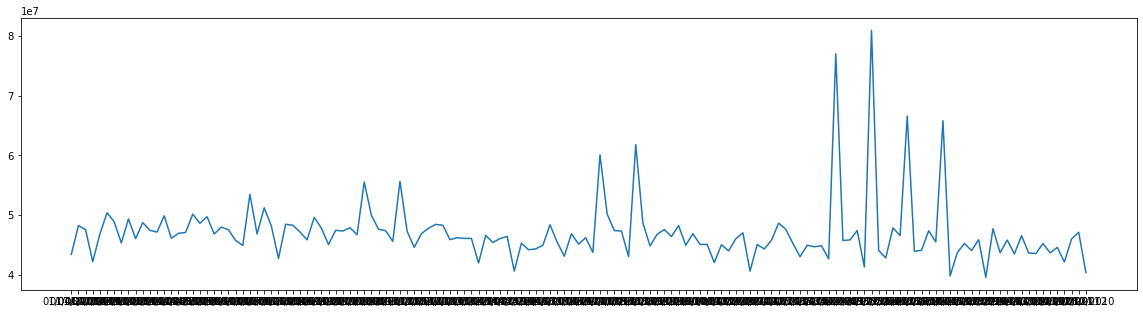

In [8]:
plt.figure(figsize=(20,5))
plt.plot(df_average_sales_week.Date, df_average_sales_week.Weekly_Sales)
plt.show()

In [9]:
df_average_sales_week.Weekly_Sales = df_average_sales_week.Weekly_Sales/1000000
df_average_sales_week.head()

Date  Weekly_Sales
0  01/04/2011     43.458991
1  01/06/2012     48.281650
2  01/07/2011     47.578520
3  01/10/2010     42.239876
4  02/03/2012     46.861035

In [10]:
data = df[['Weekly_Sales','Temperature','Fuel_Price','IsHoliday','CPI','Unemployment']]
data.head()

Weekly_Sales  Temperature  Fuel_Price  IsHoliday         CPI  Unemployment
0      24924.50        42.31       2.572      False  211.096358         8.106
1      46039.49        38.51       2.548       True  211.242170         8.106
2      41595.55        39.93       2.514      False  211.289143         8.106
3      19403.54        46.63       2.561      False  211.319643         8.106
4      21827.90        46.50       2.625      False  211.350143         8.106

### Looking for any correlation between the columns

<AxesSubplot:>

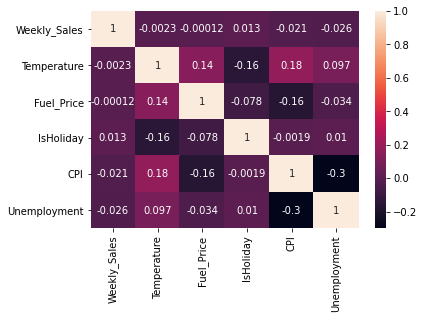

In [11]:
sns.heatmap(data.corr(), annot = True)

## Using XGBoost Regressor

In [21]:
sales_date_store = sales.groupby(["Date","Store"]).agg({"Weekly_Sales":"sum"})
sales_date_store.sort_index(inplace=True)
sales_date_store.Weekly_Sales = sales_date_store.Weekly_Sales/10000
sales_date_store.Weekly_Sales = sales_date_store.Weekly_Sales.apply(int)
data_table = pd.merge(features,sales_date_store ,  how='left', on=["Date","Store"])
data_table = pd.merge(data_table,stores[["Store","Type"]] ,  how='left', on=["Store"])
data_train = data_table[data_table.Weekly_Sales.notnull()]
data_test = data_table[data_table.Weekly_Sales.isnull()]
data_table.Date = data_table.Date.apply(lambda x: x.replace('/','-'))
data_table.Date.head()
data_table['Date'] = pd.to_datetime(data_table.Date, format='%d-%m-%Y')

In [22]:
data_table.head()

Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
0      1 2010-02-05        42.31       2.572        NaN        NaN        NaN   
1      1 2010-02-12        38.51       2.548        NaN        NaN        NaN   
2      1 2010-02-19        39.93       2.514        NaN        NaN        NaN   
3      1 2010-02-26        46.63       2.561        NaN        NaN        NaN   
4      1 2010-03-05        46.50       2.625        NaN        NaN        NaN   

   MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  Weekly_Sales  \
0        NaN        NaN  211.096358         8.106      False         164.0   
1        NaN        NaN  211.242170         8.106       True         164.0   
2        NaN        NaN  211.289143         8.106      False         161.0   
3        NaN        NaN  211.319643         8.106      False         140.0   
4        NaN        NaN  211.350143         8.106      False         155.0   

  Type  
0    A  
1    A  
2    A  
3    A  
4    A

### Imputing missing values in the dependent columns (everything other than Weekly_Sales)

In [23]:
itt = IterativeImputer()
df = itt.fit_transform(data_table[["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]]) 
data_table.MarkDown1 = df[:,0]
data_table.MarkDown2 = df[:,1]
data_table.MarkDown3 = df[:,2]
data_table.MarkDown4 = df[:,3]
data_table.MarkDown5 = df[:,4]

In [24]:
data_table['CPI'].fillna((data_table['CPI'].mean()), inplace=True)
data_table['Unemployment'].fillna((data_table['Unemployment'].mean()), inplace=True)
data_table['IsHoliday'] = data_table['IsHoliday'].map({True:0,False:1})

In [25]:
data_table["Month"] = data_table.Date.dt.month
data_table["Year"] = data_table.Date.dt.year
data_table["WeekofYear"] = data_table.Date.dt.weekofyear
data_table.drop(['Date'],axis=1,inplace=True)

e:\byteridge\programs\repos\environments\test\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


### Preparing for one hot label encoding (creating dummies for caategorical variables)

In [26]:
data_table = pd.get_dummies(data = data_table, columns = ['Type','Month','Year','WeekofYear'])

In [27]:
data_train = data_table[data_table.Weekly_Sales.notnull()]
validate_table = data_train.iloc[:305,:]
data_train = data_train.iloc[306:,:] 
data_test = data_table[data_table.Weekly_Sales.isnull()]

X = data_train.drop('Weekly_Sales', axis=1)
y = data_train['Weekly_Sales']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Training the model

In [30]:
xg_reg = xgb.XGBRegressor()

In [31]:
xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Calculating model accuracy

In [32]:
xg_reg.score(X_test,y_test)

0.9782108896757842

In [33]:
y_pred = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 8.196134


### Y_pred depicts the predicted weekly sales values (for the rows where the values were null)

In [34]:
y_pred

array([ 44.322765, 101.723625,  73.414696, ..., 100.045425, 106.85606 ,
       210.63684 ], dtype=float32)

### Predicting Weekly_Sales values for the missing values in the dataframe and imputing them

In [35]:
data_test.drop(['Weekly_Sales'],axis=1,inplace=True)
predict = xg_reg.predict(data_test)
data_test['Weekly_Sales'] = predict
data_test = data_test[['Store', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday', 'Weekly_Sales', 'Type_A', 'Type_B', 'Type_C', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12', 'Year_2010',
       'Year_2011', 'Year_2012', 'Year_2013', 'WeekofYear_1', 'WeekofYear_2',
       'WeekofYear_3', 'WeekofYear_4', 'WeekofYear_5', 'WeekofYear_6',
       'WeekofYear_7', 'WeekofYear_8', 'WeekofYear_9', 'WeekofYear_10',
       'WeekofYear_11', 'WeekofYear_12', 'WeekofYear_13', 'WeekofYear_14',
       'WeekofYear_15', 'WeekofYear_16', 'WeekofYear_17', 'WeekofYear_18',
       'WeekofYear_19', 'WeekofYear_20', 'WeekofYear_21', 'WeekofYear_22',
       'WeekofYear_23', 'WeekofYear_24', 'WeekofYear_25', 'WeekofYear_26',
       'WeekofYear_27', 'WeekofYear_28', 'WeekofYear_29', 'WeekofYear_30',
       'WeekofYear_31', 'WeekofYear_32', 'WeekofYear_33', 'WeekofYear_34',
       'WeekofYear_35', 'WeekofYear_36', 'WeekofYear_37', 'WeekofYear_38',
       'WeekofYear_39', 'WeekofYear_40', 'WeekofYear_41', 'WeekofYear_42',
       'WeekofYear_43', 'WeekofYear_44', 'WeekofYear_45', 'WeekofYear_46',
       'WeekofYear_47', 'WeekofYear_48', 'WeekofYear_49', 'WeekofYear_50',
       'WeekofYear_51', 'WeekofYear_52']]

e:\byteridge\programs\repos\environments\test\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
e:\byteridge\programs\repos\environments\test\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
data_train.append(data_test)

Store  Temperature  Fuel_Price    MarkDown1    MarkDown2    MarkDown3  \
384       3        83.79       2.653  7031.852089  3391.983532  1835.828065   
385       3        82.20       2.669  7031.852089  3391.983532  1835.828065   
386       3        81.75       2.642  7031.852089  3391.983532  1835.828065   
387       3        84.32       2.623  7031.852089  3391.983532  1835.828065   
388       3        83.32       2.608  7031.852089  3391.983532  1835.828065   
...     ...          ...         ...          ...          ...          ...   
8185     45        76.05       3.639  4842.290000   975.030000     3.000000   
8186     45        77.50       3.614  9090.480000  2268.580000   582.740000   
8187     45        79.37       3.614  3789.940000  1827.310000    85.720000   
8188     45        82.84       3.737  2961.490000  1047.070000   204.190000   
8189     45        76.06       3.804   212.020000   851.730000     2.060000   

        MarkDown4    MarkDown5         CPI  Unemployment  ...  WeekofYear_43  \
384   2675.211153  4132.216422  214.666074      7.343000  ...              0   
385   2675.211153  4132.216422  214.546322      7.346000  ...              0   
386   2675.211153  4132.216422  214.426570      7.346000  ...              0   
387   2675.211153  4132.216422  214.417648      7.346000  ...              0   
388   2675.211153  4132.216422  214.556497      7.346000  ...              0   
...           ...          ...         ...           ...  ...            ...   
8185  2449.970000  3169.690000  172.460809      7.826821  ...              0   
8186  5797.470000  1514.930000  172.460809      7.826821  ...              0   
8187   744.840000  2150.360000  172.460809      7.826821  ...              0   
8188   363.000000  1059.460000  172.460809      7.826821  ...              0   
8189    10.880000  1864.570000  172.460809      7.826821  ...              0   

      WeekofYear_44  WeekofYear_45  WeekofYear_46  WeekofYear_47  \
384               0              0              0              0   
385               0              0              0              0   
386               0              0              0              0   
387               0              0              0              0   
388               0              0              0              0   
...             ...            ...            ...            ...   
8185              0              0              0              0   
8186              0              0              0              0   
8187              0              0              0              0   
8188              0              0              0              0   
8189              0              0              0              0   

      WeekofYear_48  WeekofYear_49  WeekofYear_50  WeekofYear_51  \
384               0              0              0              0   
385               0              0              0              0   
386               0              0              0              0   
387               0              0              0              0   
388               0              0              0              0   
...             ...            ...            ...            ...   
8185              0              0              0              0   
8186              0              0              0              0   
8187              0              0              0              0   
8188              0              0              0              0   
8189              0              0              0              0   

      WeekofYear_52  
384               0  
385               0  
386               0  
387               0  
388               0  
...             ...  
8185              0  
8186              0  
8187              0  
8188              0  
8189              0  

[7884 rows x 83 columns]

### Creating a new table after imputing values into original data set from y_pred

In [37]:
new_table = data_train[['Store', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
       'IsHoliday', 'Weekly_Sales']]
new_table.head()

Store  Temperature  Fuel_Price         CPI  Unemployment  IsHoliday  \
384      3        83.79       2.653  214.666074         7.343          1   
385      3        82.20       2.669  214.546322         7.346          1   
386      3        81.75       2.642  214.426570         7.346          1   
387      3        84.32       2.623  214.417648         7.346          1   
388      3        83.32       2.608  214.556497         7.346          1   

     Weekly_Sales  
384          35.0  
385          38.0  
386          34.0  
387          35.0  
388          35.0

### Checking prediction values with test data set for weekly_sales

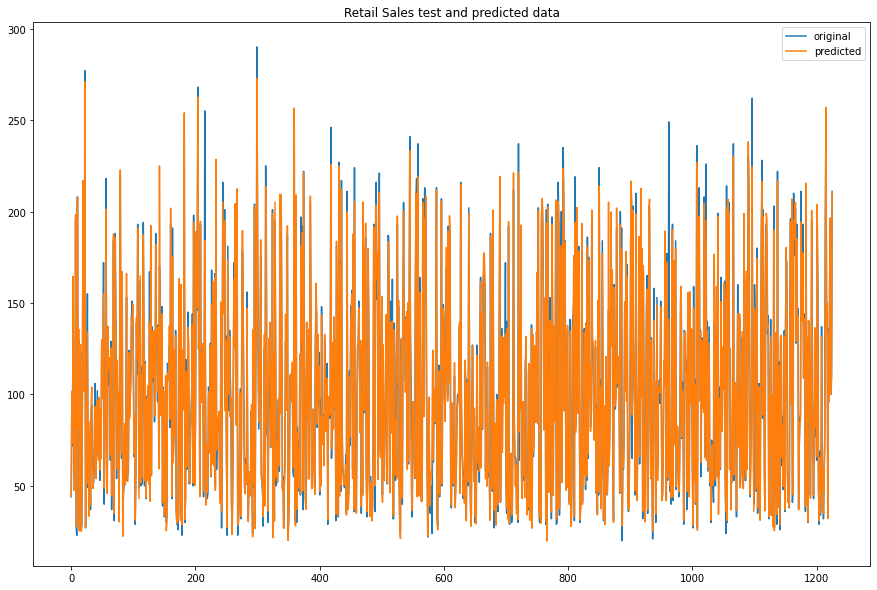

In [38]:
x_ax = range(len(y_test))
plt.figure(figsize=(15,10))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Retail Sales test and predicted data")
plt.legend()
plt.show()

### Checking prediction with validate dataset

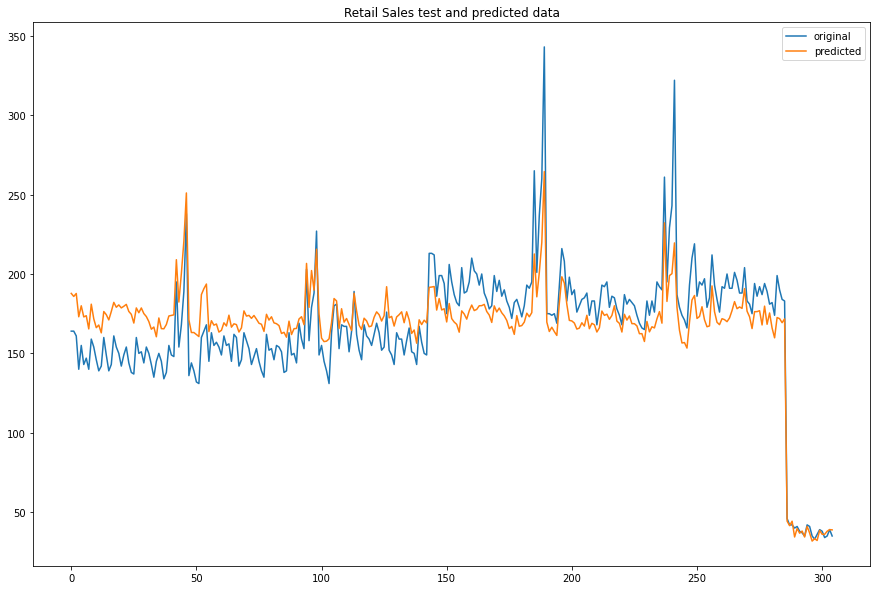

In [39]:
X = validate_table.drop('Weekly_Sales', axis=1)
y = validate_table['Weekly_Sales']
y_pred = xg_reg.predict(X)
x_ax = range(len(y))
plt.figure(figsize=(15,10))
plt.plot(x_ax, y, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Retail Sales test and predicted data")
plt.legend()
plt.show()